In [1]:
!pip uninstall -y torch torchvision torchaudio

# ÂÖàË©¶Á©©ÂÆö cu128ÔºàÂª∫Ë≠∞Ôºâ
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip -q install nbformat==5.10.4 nbconvert==7.16.6 ipywidgets==8.1.5

Found existing installation: torch 2.8.0+cu128
Uninstalling torch-2.8.0+cu128:
  Successfully uninstalled torch-2.8.0+cu128
Found existing installation: torchvision 0.23.0+cu128
Uninstalling torchvision-0.23.0+cu128:
  Successfully uninstalled torchvision-0.23.0+cu128
Found existing installation: torchaudio 2.8.0+cu128
Uninstalling torchaudio-2.8.0+cu128:
  Successfully uninstalled torchaudio-2.8.0+cu128
Looking in indexes: https://download.pytorch.org/whl/cu128
  Using cached https://download.pytorch.org/whl/cu128/torch-2.8.0%2Bcu128-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached https://download.pytorch.org/whl/cu128/torchvision-0.23.0%2Bcu128-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu128/torchaudio-2.8.0%2Bcu128-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (7.2 kB)
Using cached https://download.pytorch.org/whl/cu128/torch-2.8.0%2Bcu128-cp312-cp312-manylinux_2_28_x86_64.whl (889.0 MB)
Using cache

### Ë®≠ÂÆöË≥áÊñôÈõÜ

In [2]:
# global variable
SEED = 42
BATCH_SIZE = 128

In [3]:
# global dataset settings
import os, math, random, time
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.manual_seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device info : ', device)

transform = transforms.Compose([
    transforms.ToTensor(),             # [0,1]
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

def show_grid(tensor, nrow=10, title=None):
    """
    Âú® Notebook Áõ¥Êé•È°ØÁ§∫Â§öÂºµÂΩ±ÂÉèÂúñÊ†ºÔºà‰∏çÂ≠òÊ™îÔºâ
    - tensor: [N, C, H, W]ÔºåÂª∫Ë≠∞Âú® [0,1]ÔºõÈÄôË£°ÊúÉ normalize=True È°ØÁ§∫
    - nrow:   ÊØèÂàóË¶ÅÊéíÂ§öÂ∞ëÂºµ
    - title:  ÂúñÁâá‰∏äÊñπÁöÑÊ®ôÈ°åÔºàÂèØÁúÅÁï•Ôºâ
    """
    grid = utils.make_grid(tensor.detach().cpu(), nrow=nrow, padding=2, normalize=True)
    h = int(math.ceil(tensor.size(0) / nrow))
    plt.figure(figsize=(nrow*1.2, h*1.2))
    plt.imshow(grid.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Â≠òÂúñÂ∞èÂ∑•ÂÖ∑
def save_grid(tensor, path, nrow=10):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    grid = utils.make_grid(tensor.detach().cpu(), nrow=nrow, padding=2, normalize=True)
    utils.save_image(grid, path)
    print("Saved:", path)

device info :  cuda


### VAEÔºàVariational AutoencoderÔºâ
ÂéüÁêÜ?

Ans : ÂÉèÂ£ìÁ∏ÆÔºèËß£Â£ìÂô®„ÄÇÂÖàÊääÂúñÂ£ìÊàê‰∏ÄÂÄã„ÄåÊΩõÂú®ÂêëÈáè z„ÄçÔºåÂÜçËß£ÂõûÂúñ„ÄÇ

https://www.ibm.com/think/topics/variational-autoencoder

ÁÇ∫‰ªÄÈ∫ºËÉΩÁîüÂúñ?

Ans : Ë®ìÁ∑¥ÂÆåÊàêÂæåÔºåÂèØ‰ª•Áõ¥Êé•ÊäΩ‰∏ÄÂÄã zÔºàÈ´òÊñØÂàÜ‰ΩàÔºâ‰∏üÈÄ≤ Decoder ÁîüÊàêÊñ∞Âúñ„ÄÇ

ÊêçÂ§±ÂáΩÊï∏?

Ans : ÈáçÂª∫ÂûãBCEÔºàBCEWithLogitsLossÔºâ + KLDÔºàËÆì z Èï∑ÂæóÂÉèÊ®ôÊ∫ñÂ∏∏ÊÖãÔºâ„ÄÇ

In [4]:
# ========== VAEÔºöÁ∑®Á¢ºÂô® / Ëß£Á¢ºÂô® / Ê®°ÂûãÊú¨È´î ==========
LATENT = 30  # ÊΩõÂú®ÂêëÈáè z ÁöÑÁ∂≠Â∫¶ÔºàË≥áË®äÁì∂È†∏Â§ßÂ§öÂú®ÈÄôË£°Ë™øÔºâ

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Âç∑Á©çÁ∑®Á¢ºÂô®ÔºöÊää 28x28 ÁÅ∞ÈöéÂúñ‰∏ÄË∑ØÂ£ìÂà∞ 7x7x64 ÁöÑÁâπÂæµ
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # stride=2ÔºåÁ©∫Èñì 28->14ÔºåÈÄöÈÅì 1->32
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), # ÂÜçÊ¨°‰∏ãÊé°Ê®£ 14->7ÔºåÈÄöÈÅì 32->64
            nn.ReLU(True),
            nn.Flatten(),               # Êî§Âπ≥ÊàêÂêëÈáèÔºà64*7*7Ôºâ
        )
        # ÂÖ©ÂÄãÂÖ®ÈÄ£Êé•Â±§ÔºöËº∏Âá∫ÊØè‰∏ÄÁ∂≠ z ÁöÑ Œº Ëàá log œÉ^2ÔºàÂ∞çËßíÈ´òÊñØÔºâ
        self.fc_mu = nn.Linear(64*7*7, LATENT)
        self.fc_logvar = nn.Linear(64*7*7, LATENT)

    def forward(self, x):
        h = self.net(x)            # ÂΩ±ÂÉè ‚Üí Â£ìÁ∏ÆÁâπÂæµÂêëÈáè
        mu = self.fc_mu(h)         # ÊØèÂºµÂúñÂ∞çÊáâÁöÑÊΩõÂú®ÂùáÂÄº Œº
        logvar = self.fc_logvar(h) # ÊØèÂºµÂúñÂ∞çÊáâÁöÑÊΩõÂú® log-varianceÔºàÂ∞çÊáâ œÉ^2Ôºâ
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # ÂÖàÊääÊΩõÂú®ÂêëÈáè z ÊèêÂçáÂõû 7x7x64 ÁöÑÁ©∫ÈñìÊ†º
        self.fc = nn.Linear(LATENT, 64*7*7)
        # ÂèçÂç∑Á©çÔºà‰∏äÊé°Ê®£Ôºâ‰∏ÄË∑ØÈÇÑÂéüÂà∞ 28x28x1ÔºõÊúÄÂæå‰∏ÄÂ±§‰∏çÂÅöÊøÄÊ¥ªÔºåËº∏Âá∫ logits
        self.net = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 7->14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), # 14->28
            nn.ReLU(True),
            nn.Conv2d(16, 1, 3, 1, 1)            # Ëº∏Âá∫ logitsÔºàÊê≠ÈÖç BCEWithLogitsLossÔºâ
        )

    def forward(self, z):
        h = self.fc(z).view(-1, 64, 7, 7)  # ÂÖ®ÈÄ£Êé•ÊèêÁ∂≠ ‚Üí reshape ÊàêÁâπÂæµÂúñ
        logits = self.net(h)               # ‰∏äÊé°Ê®£ ‚Üí ÂΩ±ÂÉè logits
        return logits

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder()  # qœÜ(z|x) ÁöÑÂèÉÊï∏ÂåñÔºàËº∏Âá∫ Œº„ÄÅlogœÉ^2Ôºâ
        self.dec = Decoder()  # pŒ∏(x|z) ÁöÑÂèÉÊï∏ÂåñÔºàËº∏Âá∫ÂΩ±ÂÉè logitsÔºâ

    def reparam(self, mu, logvar):
        """
        ÈáçÂèÉÊï∏ÂåñÔºöz = Œº + œÉ ‚äô ŒµÔºåŒµ ~ N(0, I)
        Â•ΩËôïÔºöÂÖÅË®±Êää„ÄåÊäΩÊ®£„ÄçÂØ´ÊàêÂèØÂæÆÈÅãÁÆóÔºåÊ¢ØÂ∫¶ËÉΩÂÇ≥ÂõûÂà∞ Œº„ÄÅlogœÉ^2„ÄÇ
        """
        std = (0.5 * logvar).exp()     # œÉ = exp(0.5*logœÉ^2)
        eps = torch.randn_like(std)    # ÂèñÊ®£ Œµ
        return mu + eps * std          # reparameterization trick

    def forward(self, x):
        mu, logvar = self.enc(x)           # ÂÖàÊää x Á∑®Êàê Œº„ÄÅlogœÉ^2
        z = self.reparam(mu, logvar)       # ‰æùÊìö Œº„ÄÅœÉ ÂèñÊ®£ z
        logits = self.dec(z)               # Áî® z ÈÇÑÂéüÂá∫ÂΩ±ÂÉè logits
        return logits, mu, logvar

def vae_loss(recon_logits, x, mu, logvar):
    """
    Ë≠âÊìö‰∏ãÁïåÔºàELBOÔºâ:
    ÊàëÂÄëÁúüÊ≠£ÊÉ≥Â≠∏ÁöÑÊòØÂæåÈ©óÂàÜ‰Ωà p(z‚à£x)ÔºàÁúãÂà∞Ë≥áÊñô x ÂæåÔºåÊΩõËÆäÊï∏ z ÁöÑÊ©üÁéáÈï∑ÊÄéÊ®£ÔºâÔºåp(x) Ë¶ÅÊääÊâÄÊúâÂèØËÉΩÁöÑ z Á©çÂàÜËµ∑‰æÜÔºåË∂ÖÈõ£ÁÆóÔºàÂ∞çÈ´òÁ∂≠Ê®°ÂûãÂπæ‰πéÁÆó‰∏çÂá∫‰æÜÔºâÔºåÊñºÊòØ VAE Ëµ∞„ÄåËÆäÂàÜ„ÄçË∑ØÁ∑öÔºöÊâæ‰∏ÄÂÄãÂ•ΩÁÆóÁöÑËøë‰ºº qœï
	  (z‚à£x)ÔºàÁ∑®Á¢ºÂô®Ëº∏Âá∫ÁöÑÈ´òÊñØÊóèÔºâÔºåÊÉ≥Ëæ¶Ê≥ïËÆì qœï Ë≤ºËøë p(z‚à£x)„ÄÇÊúÄÁõ¥Ë¶∫ÁöÑÂÅöÊ≥ïÊòØÊúÄÂ∞èÂåñKL(ùëûùúô(ùëß‚à£ùë•) ‚à• ùëù(ùëß‚à£ùë•)),‰ΩÜÈÄôË£°Èù¢‰πüËóèËëó p(x) ÊâÄ‰ª•Ê≤íÊ≥ïÁõ¥Êé•ÊúÄÂ∞èÂåñ„ÄÇ
    ËΩâÂøµÔºöÊîπÊàêÊúÄÂ§ßÂåñ ELBOÔºåÂèóÂà∞ KL Êï£Â∫¶ÊêçÂ§±È†ÖËàáÈáçÂª∫ÊêçÂ§±È†ÖÂÖ±ÂêåÊ¢ù‰ª∂Á¥ÑÊùü‰∏ãÔºåË©≤Ëá™Á∑®Á¢ºÂô®ÁâπÂÆöËº∏Âá∫ËàáË®ìÁ∑¥Ë≥áÊñô„ÄåË≠âÊìö„ÄçÁõ∏Á¨¶ÂêàÁöÑÁ®ãÂ∫¶„ÄÇÂõ†Ê≠§ÔºåË®ìÁ∑¥‰∏ÄÂÄãËÆäÂàÜÊé®Êñ∑Ê®°Âûã‰πüÂèØ‰ª•Áî®ÊúÄÂ§ßÂåñ ELBO ‰æÜÊèèËø∞„ÄÇ
    loss = BCE + KLD Â∞±ÊòØ -ELBOÔºå„Äåloss ‰∏ãÈôç„Äç‚áî„ÄåELBO ‰∏äÂçá„ÄçÔºàÊõ¥Êé•ËøëÁúüÂØ¶Â∞çÊï∏‰ººÁÑ∂ÁöÑ‰∏ãÁïåÔºâÊâÄ‰ª•
    ELBOÁ≠âÂÉπÊúÄÂ∞èÂåñÂûãÂºèÔºöÈáçÂª∫ BCE + KL(q(z|x) || N(0,1))
    - recon_logitsÔºöDecoder Ëº∏Âá∫ logitsÔºåÊïÖ‰ΩøÁî® BCEWithLogitsLoss Êõ¥Á©©
    - xÔºöÁõÆÊ®ôÂΩ±ÂÉèÔºåÁØÑÂúç [0,1]
    - mu, logvarÔºöÁ∑®Á¢ºÂô®Ëº∏Âá∫ÁöÑÊΩõÂú®ÂàÜ‰ΩàÂèÉÊï∏
    """
    # ÈáçÂª∫È†ÖÔºöÂ∞çÊØèÂÄãÂÉèÁ¥†ÂÅö BCE, Ë°°ÈáèÂéüÂßãËº∏ÂÖ•Ë≥áÊñôËàáËß£Á¢ºÂô®Ëº∏Âá∫(ÈáçÂª∫)‰πãÈñìÁöÑÂ∑ÆÁï∞Ôºåreduction='sum' ÂÜçÈô§‰ª• batchÔºåÁ≠âÂêå per-sample sum
    bce = F.binary_cross_entropy_with_logits(recon_logits, x, reduction='sum')/x.size(0)

    # KL Ê≠£ÂâáÈ†ÖÔºöËø´‰ΩøÊΩõÂú®ËÆäÊï∏ÁöÑÂ≠∏ÁøíÁ∑®Á¢ºÊúçÂæûÈ´òÊñØÂàÜÂ∏É(Ê®ôÊ∫ñÂ∏∏ÊÖãÂàÜ‰Ωà), Â∞çËßíÈ´òÊñØÁõ∏Â∞ç N(0,1) ÁöÑÂ∞ÅÈñâËß£ÔºåÂ∞çÊØèÂÄã sample sumÔºåÊúÄÂæåÈô§ batch
    # KL = -1/2 * sum(1 + logœÉ^2 - Œº^2 - œÉ^2)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())/x.size(0)

    return bce + kld, bce, kld

# ========== Âª∫Ê®°ËàáÊúÄ‰Ω≥ÂåñÂô® ==========
vae = VAE().to(device)                                  # ÊääÊ®°Âûã‰∏üÂà∞ CPU/GPU
opt_vae = torch.optim.Adam(vae.parameters(), lr=1e-3)   # ‰ΩúÊ•≠Âª∫Ë≠∞ÔºöVAE Áî® 1e-3

# ========== Ë®ìÁ∑¥ ==========
EPOCHS_VAE = 30
for epoch in range(1, EPOCHS_VAE+1):
    vae.train()
    loss_sum, b_sum, k_sum = 0, 0, 0  # Á¥ØË®àÁ∏ΩÊêçÂ§±„ÄÅBCE„ÄÅKLDÔºàÁúãÂ≠∏ÁøíÂãïÊÖãÔºâ
    for x, _ in tqdm(train_loader, desc=f"VAE Epoch {epoch}", leave=False):
        x = x.to(device)                                 # ÂΩ±ÂÉè‰∏üÂà∞Ë£ùÁΩÆ
        recon_logits, mu, logvar = vae(x)                # ÂâçÂêëÔºöÂæóÂà∞ÈáçÂª∫ logits ËàáÊΩõÂú®ÂàÜ‰ΩàÂèÉÊï∏
        loss, bce, kld = vae_loss(recon_logits, x, mu, logvar)  # ÁÆó ELBO Â∞çÊáâÁöÑ loss
        opt_vae.zero_grad()                              # ÂÖàÊääÊ¢ØÂ∫¶Ê∏Ö‰πæÊ∑®
        loss.backward()                                  # ÂèçÂêëÂÇ≥Êí≠ÔºàËá™ÂãïÂæÆÂàÜÔºâ
        opt_vae.step()                                   # ‰æùÊ¢ØÂ∫¶Êõ¥Êñ∞ÂèÉÊï∏
        loss_sum += loss.item()
        b_sum += bce.item()
        k_sum += kld.item()
    print(f"[VAE] epoch {epoch:02d} | loss={loss_sum/len(train_loader):.3f} | "
          f"BCEWithLogitsLoss(reconstruction loss)={b_sum/len(train_loader):.3f} | kL Divergence={k_sum/len(train_loader):.3f}")

VAE Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 01 | loss=162.345 | BCEWithLogitsLoss(reconstruction loss)=142.040 | kL Divergence=20.305


VAE Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 02 | loss=110.937 | BCEWithLogitsLoss(reconstruction loss)=83.309 | kL Divergence=27.628


VAE Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 03 | loss=107.140 | BCEWithLogitsLoss(reconstruction loss)=79.345 | kL Divergence=27.795


VAE Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 04 | loss=105.490 | BCEWithLogitsLoss(reconstruction loss)=77.788 | kL Divergence=27.701


VAE Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 05 | loss=104.448 | BCEWithLogitsLoss(reconstruction loss)=76.869 | kL Divergence=27.579


VAE Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 06 | loss=103.714 | BCEWithLogitsLoss(reconstruction loss)=76.239 | kL Divergence=27.475


VAE Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 07 | loss=103.106 | BCEWithLogitsLoss(reconstruction loss)=75.741 | kL Divergence=27.366


VAE Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 08 | loss=102.625 | BCEWithLogitsLoss(reconstruction loss)=75.371 | kL Divergence=27.254


VAE Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 09 | loss=102.195 | BCEWithLogitsLoss(reconstruction loss)=75.034 | kL Divergence=27.161


VAE Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 10 | loss=101.865 | BCEWithLogitsLoss(reconstruction loss)=74.780 | kL Divergence=27.085


VAE Epoch 11:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 11 | loss=101.537 | BCEWithLogitsLoss(reconstruction loss)=74.546 | kL Divergence=26.991


VAE Epoch 12:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 12 | loss=101.242 | BCEWithLogitsLoss(reconstruction loss)=74.351 | kL Divergence=26.892


VAE Epoch 13:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 13 | loss=100.975 | BCEWithLogitsLoss(reconstruction loss)=74.152 | kL Divergence=26.823


VAE Epoch 14:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 14 | loss=100.713 | BCEWithLogitsLoss(reconstruction loss)=73.968 | kL Divergence=26.745


VAE Epoch 15:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 15 | loss=100.437 | BCEWithLogitsLoss(reconstruction loss)=73.802 | kL Divergence=26.635


VAE Epoch 16:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 16 | loss=100.273 | BCEWithLogitsLoss(reconstruction loss)=73.718 | kL Divergence=26.555


VAE Epoch 17:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 17 | loss=100.039 | BCEWithLogitsLoss(reconstruction loss)=73.576 | kL Divergence=26.463


VAE Epoch 18:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 18 | loss=99.870 | BCEWithLogitsLoss(reconstruction loss)=73.444 | kL Divergence=26.427


VAE Epoch 19:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 19 | loss=99.700 | BCEWithLogitsLoss(reconstruction loss)=73.332 | kL Divergence=26.368


VAE Epoch 20:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 20 | loss=99.513 | BCEWithLogitsLoss(reconstruction loss)=73.214 | kL Divergence=26.299


VAE Epoch 21:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 21 | loss=99.372 | BCEWithLogitsLoss(reconstruction loss)=73.141 | kL Divergence=26.232


VAE Epoch 22:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 22 | loss=99.257 | BCEWithLogitsLoss(reconstruction loss)=73.054 | kL Divergence=26.203


VAE Epoch 23:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 23 | loss=99.087 | BCEWithLogitsLoss(reconstruction loss)=72.978 | kL Divergence=26.109


VAE Epoch 24:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 24 | loss=98.961 | BCEWithLogitsLoss(reconstruction loss)=72.896 | kL Divergence=26.065


VAE Epoch 25:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 25 | loss=98.841 | BCEWithLogitsLoss(reconstruction loss)=72.792 | kL Divergence=26.049


VAE Epoch 26:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 26 | loss=98.739 | BCEWithLogitsLoss(reconstruction loss)=72.739 | kL Divergence=26.000


VAE Epoch 27:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 27 | loss=98.639 | BCEWithLogitsLoss(reconstruction loss)=72.686 | kL Divergence=25.953


VAE Epoch 28:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 28 | loss=98.534 | BCEWithLogitsLoss(reconstruction loss)=72.623 | kL Divergence=25.912


VAE Epoch 29:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 29 | loss=98.454 | BCEWithLogitsLoss(reconstruction loss)=72.576 | kL Divergence=25.878


VAE Epoch 30:   0%|          | 0/469 [00:00<?, ?it/s]

[VAE] epoch 30 | loss=98.305 | BCEWithLogitsLoss(reconstruction loss)=72.488 | kL Divergence=25.817


[Recon] Âπ≥ÂùáÈáçÂª∫ BCEÔºàË∂äÂ∞èË∂äÂ•ΩÔºâ: 0.0893


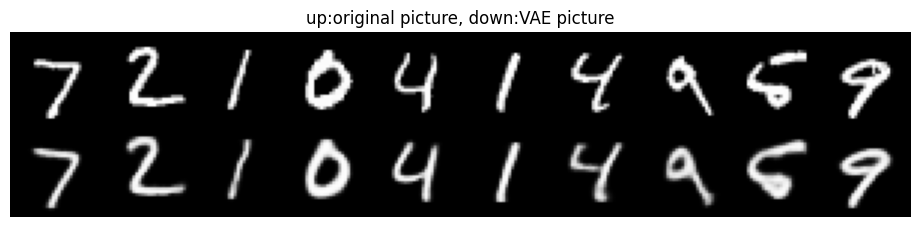

In [5]:
# ÂéüÂúñ vs ÈáçÂª∫Ôºö‰∏äÊéíÂéüÂúñ„ÄÅ‰∏ãÊéíÈáçÂª∫ÔºàÂè™È°ØÁ§∫Ôºå‰∏çÂ≠òÊ™îÔºâ
vae.eval()
with torch.no_grad():
    # Âèñ‰∏ÄÂÄã batchÔºàÂÑ™ÂÖàÁî® test_loaderÔºõÊ≤íÊúâÂ∞±Áî® train_loaderÔºâ
    try:
        batch = next(iter(test_loader))
    except NameError:
        batch = next(iter(train_loader))

    x_batch, _ = batch
    x_batch = x_batch.to(device)
    bs = x_batch.size(0)
    num_show = min(10, bs)  # È°ØÁ§∫Ââç 10 Âºµ

    # ÂâçÂêëÈáçÂª∫
    recon_logits, mu, logvar = vae(x_batch)
    x_recon = torch.sigmoid(recon_logits)

    # Á∞°ÂñÆÁöÑÈáçÂª∫ÂìÅË≥™Êï∏Â≠óÔºöÊØèÂºµÂúñÁöÑ BCEÔºàÂèÉËÄÉÁî®Ôºâ
    import torch.nn.functional as F
    bce_per_img = F.binary_cross_entropy_with_logits(
        recon_logits, x_batch, reduction='none'
    ).view(bs, -1).mean(dim=1)
    print(f"[Recon] Âπ≥ÂùáÈáçÂª∫ BCEÔºàË∂äÂ∞èË∂äÂ•ΩÔºâ: {bce_per_img.mean().item():.4f}")

    # 2xN ÁöÑÂ∞çÁÖßÔºö‰∏ä=ÂéüÂúñÔºå‰∏ã=ÈáçÂª∫
    top = x_batch[:num_show].detach().cpu()
    bottom = x_recon[:num_show].detach().cpu()
    compare_grid = torch.cat([top, bottom], dim=0)  # [2N, 1, 28, 28]
    show_grid(compare_grid, nrow=num_show, title="up:original picture, down:VAE picture")

### GAN (Generative Adversarial Network)
ÂéüÁêÜ?

Ans : Generator ÈÄ†ÂÅáÂúñÔºõDiscriminator ÊäìÂì™Ë£°ÂÅá„ÄÇ‰∫íÁõ∏ÈÄºÂà∞‰ΩçÔºåÂÅáÂúñÂ∞±Ë∂äÂÉèÁúüÁöÑ„ÄÇ

ÁÇ∫‰ªÄÈ∫ºËÉΩÁîüÂúñ?

Ans : Ë®ìÁ∑¥ÂÆåÊàêÂæåÔºåÊãøÈö®Ê©üÂô™ËÅ≤ z ‚Üí G ‚Üí Âúñ

ÊêçÂ§±ÂáΩÊï∏?

Ans : Â∞çÊäó BCEÔºàBCEWithLogitsLossÔºâ

In [6]:
NZ = 100  # Âô™ËÅ≤ z ÁöÑÁ∂≠Â∫¶ÔºàÁîüÊàêÂô®Ëº∏ÂÖ•ÔºâÔºõË∂äÂ§ßÊΩõÂú®Á©∫ÈñìË∂äË±êÂØåÔºå‰ΩÜ‰πüÊõ¥Èõ£Â≠∏

class G(nn.Module):
    def __init__(self):
        super().__init__()
        # ÂÖàÁî®‰∏ÄÂ±§ÂÖ®ÈÄ£Êé•Êää z ÊäïÂΩ±Âà∞ 7x7x256 ÁöÑ„ÄåÂ∞èÁâπÂæµÂúñ„Äç‰ΩúÁÇ∫Ëµ∑Èªû
        self.fc = nn.Linear(NZ, 256*7*7)
        # ÂèçÂç∑Á©çÂ†ÜÁñäÔºöÈÄêÊ≠•‰∏äÊé°Ê®£Âà∞ 28x28x1ÔºàMNISTÔºâ
        self.net = nn.Sequential(
            nn.BatchNorm2d(256),                   # ÁîüÊàêÂô®Â∏∏Áî® BN Á©©ÂÆöË®ìÁ∑¥ËàáÊîæÂ§ßÊ¢ØÂ∫¶
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 7->14 ‰∏äÊé°Ê®£
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 14->28 ‰∏äÊé°Ê®£
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 1, 3, 1, 1)              # Ëº∏Âá∫ logitsÔºõÁ®çÂæåÁ∂ì Sigmoid Âà∞ [0,1]
        )
    def forward(self, z):
        # z: [B, NZ]
        h = self.fc(z).view(-1, 256, 7, 7)         # [B, 256, 7, 7]
        logits = self.net(h)                        # [B, 1, 28, 28]
        x = torch.sigmoid(logits)                   # Êò†Âà∞ [0,1]ÔºåËàáÁúüÂØ¶ÂΩ±ÂÉèÂ∞∫Â∫¶‰∏ÄËá¥
        return x

class D(nn.Module):
    def __init__(self):
        super().__init__()
        # Âà§Âà•Âô®ÔºöËº∏ÂÖ• 28x28x1ÔºåËº∏Âá∫‰∏ÄÂÄã logitÔºàË∂äÂ§ßË∂äÂÉèÁúüÔºâ
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),              # 28->14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),            # 14->7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1)                   # ÂñÆ‰∏Ä logitÔºõBCEWithLogitsLoss Áõ¥Êé•ÂêÉ
        )
    def forward(self, x):
        # x: [B, 1, 28, 28]
        return self.net(x).view(-1)                 # [B]ÔºåÊØèÂÄãÊòØ logit

G_gan = G().to(device)
D_gan = D().to(device)

# ÂÖ©ÂÄãÂÑ™ÂåñÂô®ÂàÜÈñãÔºõDCGAN Á∂ìÂÖ∏Ë®≠ÂÆö betas=(0.5, 0.999) Âπ´Âä©Á©©ÂÆö
opt_G = torch.optim.Adam(G_gan.parameters(), lr=1e-4, betas=(0.5, 0.999))  # TTUR: G Â∞è‰∏ÄÈªû
opt_D = torch.optim.Adam(D_gan.parameters(), lr=4e-4, betas=(0.5, 0.999))  # TTUR: D Â§ß‰∏ÄÈªû
bce = nn.BCEWithLogitsLoss()  # Ê≥®ÊÑèÔºöÈÄôÂÄã loss ÊúüÊúõËº∏ÂÖ•ÊòØ„Äålogits„ÄçÔºå‰∏çÊòØ sigmoid ÂæåÊ©üÁéá

# ==== Ë®ìÁ∑¥Âæ™Áí∞ÔºàÈÄêÊ≠•‰∏≠ÊñáË®ªËß£Ôºâ ================================================
from tqdm.auto import tqdm

EPOCHS_GAN = 60

for epoch in range(1, EPOCHS_GAN+1):
    D_loss_sum = G_loss_sum = 0.0
    for x_real, _ in tqdm(train_loader, desc=f"GAN Epoch {epoch}", leave=False):
        x_real = x_real.to(device)       # ÁúüÂØ¶ÂΩ±ÂÉèÔºà[0,1]Ôºâ
        bs = x_real.size(0)

        # -------- 1) ÂÖàË®ìÁ∑¥ DiscriminatorÔºàËÆì D Êõ¥ÊúÉÂàÜËæ®Ôºâ --------
        # ÁîüÊàêÂÅáÂúñÔºàdetach ÂàáÊñ∑ G ÁöÑÊ¢ØÂ∫¶ÔºåÈÅøÂÖç D ÁöÑÊõ¥Êñ∞ÂõûÊµÅÂà∞ GÔºâ
        z = torch.randn(bs, NZ, device=device)
        x_fake = G_gan(z).detach()
        # D ÂàÜÂà•ÁúãÁúüËàáÂÅáÔºåËº∏Âá∫ logits
        logits_real = D_gan(x_real)
        logits_fake = D_gan(x_fake)
        # ÁúüÂØ¶Ê®ôÁ±§ÂÅö„Äålabel smoothing„ÄçÔºöÂ∞á 1 ÊîπÁÇ∫ U[0.8,1.0]ÔºåÈôç‰Ωé D ÁöÑÈÅéÂ∫¶Ëá™‰ø°ÔºåÊèêÂçáÁ©©ÂÆöÊÄß
        real_targets = torch.empty(bs, device=device).uniform_(0.8, 1.0)
        fake_targets = torch.zeros(bs, device=device)  # ÂÅáÊ®£Êú¨Ê®ôÁ±§ = 0
        # D ÁöÑ loss = ÁúüÊ®£Êú¨Âà§Áúü + ÂÅáÊ®£Êú¨Âà§ÂÅá
        loss_D = bce(logits_real, real_targets) + bce(logits_fake, fake_targets)
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # -------- 2) ÂÜçË®ìÁ∑¥ GeneratorÔºàËÆì G Êõ¥ÊúÉÈ®ôÈÅé DÔºâ --------
        # ÈáçÊñ∞ÂèñÂô™ËÅ≤ÔºàÊàñ‰∏çÈáçÂèñ‰πüË°åÔºâÔºåÈÄôÊ¨°‰∏ç detachÔºåËÆìÊ¢ØÂ∫¶ÂõûÂà∞ G
        z = torch.randn(bs, NZ, device=device)
        x_fake = G_gan(z)
        logits_fake = D_gan(x_fake)
        # Â∞ç G ‰æÜË™™ÔºåÂÆÉÂ∏åÊúõ„ÄåD Ë™çÁÇ∫ÂÅáÁöÑ‰πüÊòØÁúüÁöÑ„Äç‚Üí Ê®ôÁ±§=1
        real_targets_for_G = torch.ones(bs, device=device)
        loss_G = bce(logits_fake, real_targets_for_G)
        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        D_loss_sum += loss_D.item()
        G_loss_sum += loss_G.item()

    print(f"[GAN] epoch {epoch:02d} | D={D_loss_sum/len(train_loader):.3f} | G={G_loss_sum/len(train_loader):.3f}")

GAN Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 01 | D=0.632 | G=2.774


GAN Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 02 | D=0.651 | G=2.286


GAN Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 03 | D=0.820 | G=1.836


GAN Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 04 | D=0.829 | G=1.828


GAN Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 05 | D=0.843 | G=1.827


GAN Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 06 | D=0.837 | G=1.863


GAN Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 07 | D=0.819 | G=1.920


GAN Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 08 | D=0.822 | G=1.935


GAN Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 09 | D=0.819 | G=1.952


GAN Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 10 | D=0.815 | G=1.983


GAN Epoch 11:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 11 | D=0.824 | G=1.996


GAN Epoch 12:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 12 | D=0.833 | G=1.974


GAN Epoch 13:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 13 | D=0.816 | G=2.002


GAN Epoch 14:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 14 | D=0.838 | G=2.020


GAN Epoch 15:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 15 | D=0.822 | G=1.983


GAN Epoch 16:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 16 | D=0.823 | G=2.023


GAN Epoch 17:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 17 | D=0.829 | G=2.012


GAN Epoch 18:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 18 | D=0.832 | G=2.028


GAN Epoch 19:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 19 | D=0.838 | G=2.021


GAN Epoch 20:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 20 | D=0.836 | G=2.017


GAN Epoch 21:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 21 | D=0.833 | G=2.004


GAN Epoch 22:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 22 | D=0.838 | G=2.001


GAN Epoch 23:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 23 | D=0.848 | G=1.992


GAN Epoch 24:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 24 | D=0.842 | G=1.983


GAN Epoch 25:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 25 | D=0.843 | G=1.981


GAN Epoch 26:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 26 | D=0.858 | G=1.980


GAN Epoch 27:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 27 | D=0.861 | G=1.990


GAN Epoch 28:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 28 | D=0.857 | G=1.971


GAN Epoch 29:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 29 | D=0.863 | G=1.965


GAN Epoch 30:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 30 | D=0.859 | G=1.975


GAN Epoch 31:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 31 | D=0.865 | G=1.956


GAN Epoch 32:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 32 | D=0.869 | G=1.946


GAN Epoch 33:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 33 | D=0.865 | G=1.957


GAN Epoch 34:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 34 | D=0.872 | G=1.957


GAN Epoch 35:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 35 | D=0.871 | G=1.957


GAN Epoch 36:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 36 | D=0.872 | G=1.966


GAN Epoch 37:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 37 | D=0.874 | G=1.953


GAN Epoch 38:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 38 | D=0.878 | G=1.951


GAN Epoch 39:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 39 | D=0.876 | G=1.954


GAN Epoch 40:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 40 | D=0.883 | G=1.929


GAN Epoch 41:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 41 | D=0.881 | G=1.946


GAN Epoch 42:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 42 | D=0.880 | G=1.945


GAN Epoch 43:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 43 | D=0.880 | G=1.923


GAN Epoch 44:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 44 | D=0.876 | G=1.945


GAN Epoch 45:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 45 | D=0.878 | G=1.933


GAN Epoch 46:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 46 | D=0.886 | G=1.941


GAN Epoch 47:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 47 | D=0.880 | G=1.946


GAN Epoch 48:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 48 | D=0.882 | G=1.935


GAN Epoch 49:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 49 | D=0.880 | G=1.929


GAN Epoch 50:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 50 | D=0.881 | G=1.943


GAN Epoch 51:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 51 | D=0.883 | G=1.940


GAN Epoch 52:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 52 | D=0.889 | G=1.933


GAN Epoch 53:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 53 | D=0.878 | G=1.940


GAN Epoch 54:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 54 | D=0.884 | G=1.933


GAN Epoch 55:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 55 | D=0.890 | G=1.940


GAN Epoch 56:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 56 | D=0.886 | G=1.949


GAN Epoch 57:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 57 | D=0.887 | G=1.949


GAN Epoch 58:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 58 | D=0.889 | G=1.926


GAN Epoch 59:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 59 | D=0.887 | G=1.939


GAN Epoch 60:   0%|          | 0/469 [00:00<?, ?it/s]

[GAN] epoch 60 | D=0.895 | G=1.922


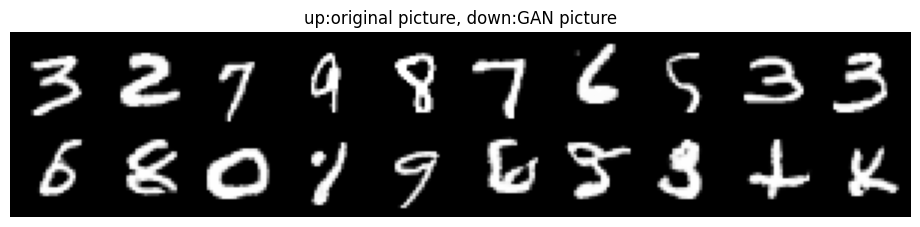

In [7]:
# ==== È°ØÁ§∫ÔºöÁúüÂØ¶Âúñ vs ÁîüÊàêÂúñ Â∞çÁÖßÔºà‰∏äÊéíÁúüÂØ¶ / ‰∏ãÊéíÁîüÊàêÔºâ ==========================
G_gan.eval()
with torch.no_grad():
    # Âèñ‰∏ÄÂÄã batch Áï∂‰ΩúÁúüÂØ¶Â∞çÁÖß
    real_batch, _ = next(iter(train_loader))
    real_batch = real_batch.to(device)
    num_show = min(10, real_batch.size(0))  # È°ØÁ§∫Ââç 10 Âºµ

    # ÁîüÊàêÂêåÊï∏ÈáèÁöÑÂÅáÂúñ
    z = torch.randn(num_show, NZ, device=device)
    fake_batch = G_gan(z)

    # ÁµÑÊàê 2√óN ÁöÑÂúñÔºö‰∏ä=ÁúüÂØ¶Ôºå‰∏ã=ÁîüÊàê
    top = real_batch[:num_show].detach().cpu()
    bottom = fake_batch[:num_show].detach().cpu()
    compare = torch.cat([top, bottom], dim=0)  # [2N,1,28,28]
    show_grid(compare, nrow=num_show, title="up:original picture, down:GAN picture")

### cGANÔºàConditional GANÔºâ
ÂéüÁêÜ?

Ans : Âú® GAN ‰∏äÂä†„ÄåÊ¢ù‰ª∂„Äç„ÄÇ‰Ω†ÂëäË®¥ÂÆÉ„ÄåÊàëÊÉ≥Ë¶Å 7„ÄçÔºåÂÆÉÊâçÊúÉÁîü 7„ÄÇ

ÁÇ∫‰ªÄÈ∫ºËÉΩÁîüÂúñ?

Ans : Êää labelÔºàone-hotÔºâË∑üÂô™ËÅ≤‰∏ÄËµ∑‰∏üÁµ¶ GÔºõD ‰πüÁúãÂúñÔºãlabel„ÄÇ

ÊêçÂ§±ÂáΩÊï∏?

Ans : Â∞çÊäó BCEÔºàBCEWithLogitsLossÔºâ

In [8]:
# Ê¢ù‰ª∂ GANÔºàcGANÔºâÔºöÂú® G/D ÈÉΩÈ§µÂÖ•È°ûÂà• y ‰ΩúÁÇ∫Ê¢ù‰ª∂
NZ = 100        # Âô™ËÅ≤ z ÁöÑÁ∂≠Â∫¶ÔºàÁîüÊàêÂô®Ëº∏ÂÖ•Ôºâ
NUM_CLASSES = 10
EMB = 16        # È°ûÂà•ÂµåÂÖ•ÂêëÈáèÁöÑÁ∂≠Â∫¶ÔºàË∂äÂ§ßË∂äÈùàÊ¥ªÔºå‰ΩÜ‰πüÊõ¥Èõ£Â≠∏Ôºâ

class CG_G(nn.Module):
    """
    ÁîüÊàêÂô® G(z, y)ÔºöÊää„ÄåÂô™ËÅ≤ z + È°ûÂà•ÂµåÂÖ• e(y)„ÄçÊãºÊé•ÂæåÔºåÈÄêÊ≠•‰∏äÊé°Ê®£Âà∞ 28√ó28√ó1„ÄÇ
    ÊúÄÂæåËº∏Âá∫ logits Á∂ì Sigmoid Âà∞ [0,1]ÔºåËàá MNIST ÁúüÂØ¶ÂΩ±ÂÉèÂ∞∫Â∫¶‰∏ÄËá¥„ÄÇ
    """
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(NUM_CLASSES, EMB)       # ÊääÊï¥Êï∏Ê®ôÁ±§ y Êò†Âà∞ EMB Á∂≠ÁöÑÈÄ£Á∫åÂêëÈáè
        self.fc = nn.Linear(NZ + EMB, 256*7*7)            # ÂÖàÊäïÂΩ±Âà∞ 7√ó7√ó256 Â∞èÁâπÂæµÂúñ
        self.net = nn.Sequential(
            nn.BatchNorm2d(256),                          # ÁîüÊàêÂô®Â∏∏Áî® BN Âπ´Âä©Á©©ÂÆö
            nn.ConvTranspose2d(256, 128, 4, 2, 1),        # 7->14 ‰∏äÊé°Ê®£
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),         # 14->28 ‰∏äÊé°Ê®£
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 1, 3, 1, 1)                     # Ëº∏Âá∫ logitsÔºõÁ®çÂæåËµ∞ Sigmoid
        )
    def forward(self, z, y):
        e = self.embed(y)                                  # e(y): [B, EMB]
        h = self.fc(torch.cat([z, e], dim=1)).view(-1, 256, 7, 7)
        logits = self.net(h)
        return torch.sigmoid(logits)                       # Êò†Âà∞ [0,1]

class CG_D(nn.Module):
    """
    Âà§Âà•Âô® D(x, y)ÔºöÊääÈ°ûÂà• y Áï´Êàê 28√ó28 ÁöÑ„ÄåÊ¢ù‰ª∂Âúñ„ÄçÔºåËàáÂΩ±ÂÉèÂú® channel Á∂≠Â∫¶ÊãºÊé•ÔºåËº∏Âá∫ÁúüÂØ¶ÊÄßÁöÑ logit„ÄÇ
    """
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(NUM_CLASSES, 28*28)      # Â∞á y Áï´Êàê‰∏ÄÂºµ 28√ó28 ÁöÑ„ÄåÊ¢ù‰ª∂Âúñ„Äç
        self.conv = nn.Sequential(
            nn.Conv2d(2, 64, 4, 2, 1),                     # Ëº∏ÂÖ•ÈÄöÈÅì=2ÔºàÂΩ±ÂÉè1 + Ê¢ù‰ª∂1ÔºâÔºå28->14
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, 4, 2, 1),                   # 14->7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1)                          # Ëº∏Âá∫ÂñÆ‰∏Ä logitÔºàË∂äÂ§ßË∂äÂÉèÁúüÔºâ
        )
    def forward(self, x, y):
        ymap = self.embed(y).view(-1, 1, 28, 28)           # Êää y Áï´Êàê [B,1,28,28]
        x_in = torch.cat([x, ymap], dim=1)                 # [B,2,28,28]
        return self.conv(x_in).view(-1)                    # [B]

G_cgan = CG_G().to(device)
D_cgan = CG_D().to(device)

opt_Gc = torch.optim.Adam(G_cgan.parameters(), lr=2e-4, betas=(0.5, 0.999))  # DCGAN Á∂ìÂÖ∏Ë®≠ÂÆö
opt_Dc = torch.optim.Adam(D_cgan.parameters(), lr=2e-4, betas=(0.5, 0.999))
bce = nn.BCEWithLogitsLoss()        # Ê≥®ÊÑèÔºöÈÄôÂÄã loss Áõ¥Êé•ÂêÉ„Äålogits„ÄçÔºå‰∏çÁî®ÊâãÂãï sigmoid

EPOCHS_CGAN = 30

for epoch in range(1, EPOCHS_CGAN+1):
    D_loss_sum = G_loss_sum = 0.0
    for x_real, y in tqdm(train_loader, desc=f"cGAN Epoch {epoch}", leave=False):
        x_real, y = x_real.to(device), y.to(device)
        bs = x_real.size(0)

        # ---- 1) ÂÖàÊõ¥Êñ∞ DÔºàËÆìÂà§Âà•Âô®Êõ¥ÊúÉÂàÜËæ®Ôºâ ----
        # ÁîüÊàêÊ¢ù‰ª∂ÂÅáÂúñÔºàdetach ÂàáÊñ∑Â∞ç G ÁöÑÊ¢ØÂ∫¶Ôºâ
        z = torch.randn(bs, NZ, device=device)
        x_fake = G_cgan(z, y).detach()

        # D Â∞çÁúüÂØ¶/ÁîüÊàê ÂêÑÂá∫‰∏ÄÂÄã logit
        logits_real = D_cgan(x_real, y)
        logits_fake = D_cgan(x_fake, y)

        # Label smoothingÔºöÁúüÂØ¶Ê®ôÁ±§ U[0.8,1.0]ÔºåÈôç‰Ωé D ÁöÑÈÅéÂ∫¶Ëá™‰ø°Ôºå‰ΩøÂ∞çÊäóÊõ¥Á©©
        real_targets = torch.empty(bs, device=device).uniform_(0.8, 1.0)
        fake_targets = torch.zeros(bs, device=device)

        # D ÁöÑ loss = ÁúüÊ®£Êú¨Âà§Áúü + ÂÅáÊ®£Êú¨Âà§ÂÅá
        loss_D = bce(logits_real, real_targets) + bce(logits_fake, fake_targets)
        opt_Dc.zero_grad()
        loss_D.backward()
        opt_Dc.step()

        # ---- 2) ÂÜçÊõ¥Êñ∞ GÔºàËÆìÁîüÊàêÂô®Êõ¥ÊúÉÈ®ôÈÅé DÔºâ ----
        z = torch.randn(bs, NZ, device=device)
        x_fake = G_cgan(z, y)                   # ÈÄôÊ¨°‰∏ç detachÔºåÊ¢ØÂ∫¶ÂõûÂà∞ G
        logits_fake = D_cgan(x_fake, y)

        # Â∞ç G ‰æÜË™™ÔºåÂ∏åÊúõ D ÊääÂÅáÂúñÁï∂Áúü ‚áí Ê®ôÁ±§=1
        loss_G = bce(logits_fake, torch.ones(bs, device=device))
        opt_Gc.zero_grad()
        loss_G.backward()
        opt_Gc.step()

        D_loss_sum += loss_D.item()
        G_loss_sum += loss_G.item()

    print(f"[cGAN] epoch {epoch:02d} | D={D_loss_sum/len(train_loader):.3f} | G={G_loss_sum/len(train_loader):.3f}")

cGAN Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 01 | D=1.185 | G=1.092


cGAN Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 02 | D=1.206 | G=1.071


cGAN Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 03 | D=1.288 | G=0.983


cGAN Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 04 | D=1.339 | G=0.900


cGAN Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 05 | D=1.352 | G=0.874


cGAN Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 06 | D=1.361 | G=0.868


cGAN Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 07 | D=1.365 | G=0.855


cGAN Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 08 | D=1.369 | G=0.852


cGAN Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 09 | D=1.372 | G=0.849


cGAN Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 10 | D=1.374 | G=0.847


cGAN Epoch 11:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 11 | D=1.376 | G=0.840


cGAN Epoch 12:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 12 | D=1.378 | G=0.840


cGAN Epoch 13:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 13 | D=1.378 | G=0.839


cGAN Epoch 14:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 14 | D=1.379 | G=0.838


cGAN Epoch 15:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 15 | D=1.379 | G=0.832


cGAN Epoch 16:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 16 | D=1.380 | G=0.834


cGAN Epoch 17:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 17 | D=1.378 | G=0.834


cGAN Epoch 18:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 18 | D=1.379 | G=0.832


cGAN Epoch 19:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 19 | D=1.380 | G=0.830


cGAN Epoch 20:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 20 | D=1.378 | G=0.825


cGAN Epoch 21:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 21 | D=1.380 | G=0.826


cGAN Epoch 22:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 22 | D=1.380 | G=0.827


cGAN Epoch 23:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 23 | D=1.379 | G=0.824


cGAN Epoch 24:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 24 | D=1.380 | G=0.822


cGAN Epoch 25:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 25 | D=1.380 | G=0.824


cGAN Epoch 26:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 26 | D=1.380 | G=0.822


cGAN Epoch 27:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 27 | D=1.380 | G=0.822


cGAN Epoch 28:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 28 | D=1.379 | G=0.822


cGAN Epoch 29:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 29 | D=1.379 | G=0.822


cGAN Epoch 30:   0%|          | 0/469 [00:00<?, ?it/s]

[cGAN] epoch 30 | D=1.379 | G=0.820


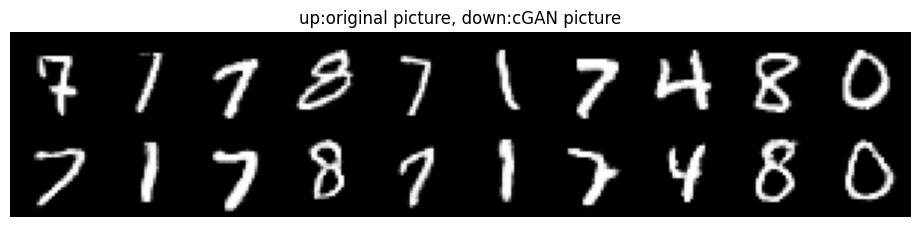

In [9]:
# ÂæûË≥áÊñôÊäì‰∏ÄÂÄãÂ∞èÊâπÊ¨°ÔºåËÆìÁîüÊàêÂô®Áî®„ÄåÁõ∏ÂêåÁöÑ y„ÄçÁîüÊàêÂ∞çÁÖß
G_cgan.eval()
with torch.no_grad():
    real_batch, y_batch = next(iter(train_loader))          # Âèñ‰∏ÄÊâπÁúüÂØ¶ÂúñËàáÂÖ∂Ê®ôÁ±§
    real_batch = real_batch.to(device)
    y_batch = y_batch.to(device)
    num_show = min(10, real_batch.size(0))                  # È°ØÁ§∫Ââç 10 Âºµ

    z = torch.randn(num_show, NZ, device=device)
    fake_batch = G_cgan(z, y_batch[:num_show])              # Áî®Áõ∏ÂêåÁöÑ y ÁîüÊàê

    # ÁµÑ 2√óN ÂúñÔºö‰∏ä=ÁúüÂØ¶„ÄÅ‰∏ã=ÁîüÊàêÔºàÂêå‰∏ÄÊ¨ÑÊòØÂêå‰∏ÄÂÄãÊ®ôÁ±§Ôºâ
    top = real_batch[:num_show].detach().cpu()
    bottom = fake_batch[:num_show].detach().cpu()
    compare = torch.cat([top, bottom], dim=0)               # [2N,1,28,28]
    show_grid(compare, nrow=num_show, title="up:original picture, down:cGAN picture")

### DiffusionÔºàDDPM È°ûÔºâ
ÂéüÁêÜ?

Ans : ÂÖàÊääÁúüÂúñÈÄêÊ≠•Âä†Âô™Âà∞ÂÖ®ÊòØÈõúË®äÔºàforwardÔºâÔºõË®ì‰∏ÄÂÄãÊ®°ÂûãÂ≠∏ÊúÉ„ÄåÊØè‰∏ÄÊ≠•ÊÄéÈ∫ºÂéªÂô™„ÄçÔºàreverseÔºâ„ÄÇ

ÁÇ∫‰ªÄÈ∫ºËÉΩÁîüÂúñ?

Ans : ÂæûÁ¥îÂô™ËÅ≤ÈñãÂßãÔºåÊåâÊ≠•È©üÊÖ¢ÊÖ¢ÂéªÂô™ÔºåÊúÄÂæåÂæóÂà∞Ê∏ÖÊ•öÁöÑÂúñ„ÄÇ

ÊêçÂ§±ÂáΩÊï∏?

Ans : È†êÊ∏¨Âô™ËÅ≤ÁöÑ MSEÔºõÂ∏∏Áî®ÊñºÂ∞èÂûã U-Net„ÄÇ

In [10]:
# ===== ÊôÇÈñìÂµåÂÖ•ÔºöÊääÈõ¢Êï£ÊôÇÈñìÊ≠• t Êò†ÊàêÈÄ£Á∫åÂêëÈáèÔºåÁî®ÊñºË™øÂà∂ÊØèÂÄãÊÆòÂ∑ÆÂ°ä =====
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim  # Ëº∏Âá∫ÂêëÈáèÁ∂≠Â∫¶ÔºàÂÅ∂Êï∏Ôºâ

    def forward(self, t):
        # t: [B] Êàñ [B,]ÔºåÈÄöÂ∏∏ÊòØ 0..T-1 ÁöÑÊï¥Êï∏Ôºà‰πüÂèØËΩâ floatÔºâ
        device = t.device
        half = self.dim // 2                      # ‰∏ÄÂçäÁ∂≠Â∫¶Áµ¶ sinÔºå‰∏ÄÂçäÁµ¶ cos
        freq_step = math.log(10000) / (half - 1)  # È†ªÁéáÈñìË∑ù
        freqs = torch.exp(torch.arange(half, device=device) * -freq_step)  # [half]
        # Â§ñÁ©çÔºöÊØèÂÄã batch ÁöÑ t Êì¥Â±ï‰πò‰∏ä‰∏çÂêåÈ†ªÁéá
        angles = t[:, None] * freqs[None, :]      # [B, half]
        emb = torch.cat([angles.sin(), angles.cos()], dim=1)  # [B, dim]
        return emb

# ===== ÊÆòÂ∑ÆÂ°äÔºöËº∏ÂÖ• + ÊôÇÈñìË™øÂà∂ÔºåGroupNorm + SiLUÔºåÊØîËºÉÁ©© =====
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )
        # ÊôÇÈñìÂêëÈáèÁî® MLP Êò†Âà∞ÈÄöÈÅìÁ∂≠Â∫¶Ôºå‰ΩúÁÇ∫Ë™øÂà∂ÂÅèÁΩÆÂä†ÈÄ≤ÁâπÂæµ
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_dim, out_ch)
        )
        # Ëã•ÈÄöÈÅìÊï∏ËÆä‰∫ÜÔºåËµ∞ 1x1 ÊÆòÂ∑ÆÂ∞çÈΩäÔºõÂê¶Ââá Identity
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        t = self.time_mlp(t_emb)[:, :, None, None]  # [B, out_ch, 1, 1]
        h = h + t                                   # ÊôÇÈñìË™øÂà∂
        h = self.block2(h)
        return h + self.res_conv(x)                 # ÊÆòÂ∑ÆÈÄ£Êé•

# ===== Â∞è U-NetÔºö‰∏ãÊé°Ê®£‚Üí‰∏≠ÈñìÂ±§‚Üí‰∏äÊé°Ê®£ÔºõÊØèÂ±§ÈÉΩÂêÉÊôÇÈñìË™øÂà∂ =====
class SmallUNet(nn.Module):
    def __init__(self, t_dim=64):
        super().__init__()
        # ÂÖàÁî®Ê≠£Âº¶‰ΩçÁΩÆÂµåÂÖ•Êää t ËΩâÊàêÂêëÈáèÔºåÂÜçÁ∂ìÈÅé‰∏ÄÂÄãÂ∞è MLP
        self.tok = SinusoidalPosEmb(t_dim//2)
        self.time_mlp = nn.Sequential(nn.Linear(t_dim, t_dim), nn.SiLU())

        # Encoder/down
        self.down1 = ResidualBlock(1, 32, t_dim)   # 1->32 ÈÄöÈÅì
        self.down2 = ResidualBlock(32, 64, t_dim)  # 32->64
        self.pool = nn.AvgPool2d(2)                # Á∞°ÂñÆ‰∏ãÊé°Ê®£Ôºà28->14Ôºâ

        # Mid
        self.mid = ResidualBlock(64, 64, t_dim)

        # Decoder/up
        self.up1 = ResidualBlock(64, 32, t_dim)    # 64->32
        self.up2 = ResidualBlock(32, 16, t_dim)    # 32->16
        self.final = nn.Conv2d(16, 1, 1)           # Ëº∏Âá∫ 1 ÈÄöÈÅìÔºàÈ†êÊ∏¨Âô™ËÅ≤ ŒµÃÇÔºâ

    def forward(self, x, t):
        # t ÂèØËÉΩÊòØ intÔºõÈÄôË£°ÊääÂÆÉÈÄÅÈÄ≤‰ΩçÁΩÆÂµåÂÖ•ÂæåÔºåÊé• MLP
        t_emb = self.tok(t)                         # [B, t_dim//2]
        t_emb = torch.cat([t_emb, t_emb], dim=1)    # ÊãºÊé•Êàê [B, t_dim]ÔºàÂÅ∑Êá∂ËÆìÁ∂≠Â∫¶Â∞çÈΩäÔºâ
        t_emb = self.time_mlp(t_emb)                # [B, t_dim]

        # Encoder
        h1 = self.down1(x, t_emb)                   # [B,32,28,28]
        h2 = self.pool(h1)                          # [B,32,14,14]
        h2 = self.down2(h2, t_emb)                  # [B,64,14,14]

        # Mid
        h3 = self.mid(h2, t_emb)                    # [B,64,14,14]

        # DecoderÔºàÈÄôË£°Ê≤íÊúâ U-Net ÁöÑ skip Êé•Ôºå‰ΩÜË∂≥Â§†Ë∑ë MNISTÔºâ
        h4 = F.interpolate(h3, scale_factor=2, mode='nearest')  # 14->28
        h4 = self.up1(h4, t_emb)                    # [B,32,28,28]
        h5 = self.up2(h4, t_emb)                    # [B,16,28,28]
        out = self.final(h5)                        # [B,1,28,28]ÔºåÈ†êÊ∏¨Âô™ËÅ≤ ŒµÃÇ
        return out

# ===== Âô™ËÅ≤Ê≠•Êï∏ÔºàT Ë∂äÂ§ßË∂äÁ©©‰ΩÜË∂äÊÖ¢ÔºõÁ§∫ÁØÑÁî® 200Ôºâ=====
T = 200
beta = torch.linspace(1e-4, 0.02, T, device=device)  # Á∑öÊÄß beta scheduleÔºàÁ∞°ÂñÆÂ•ΩÁî®Ôºâ
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)              # Á©çÁ¥Ø‰πòÁ©çÔºö\bar{Œ±}_t = ‚àè_{s‚â§t} Œ±_s

# ===== ÂâçÂêëÊìæÂãï q(x_t|x_0)Ôºö‰∏ÄÊ¨°ÂÖ¨ÂºèÊää x_0 Âä†Âô™Âà∞ x_t =====
def q_sample(x0, t, noise=None):
    """
    x0: ‰πæÊ∑®Âúñ [B,1,28,28]
    t:  ÊØèÂºµÂúñÂ∞çÊáâÁöÑÊ≠•Êï∏ [B] (0..T-1)
    ÂõûÂÇ≥Ôºöx_t = sqrt(\bar{Œ±}_t) * x0 + sqrt(1-\bar{Œ±}_t) * Œµ
    """
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_ab = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_one_minus_ab = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    return sqrt_ab * x0 + sqrt_one_minus_ab * noise

# ===== Ë®ìÁ∑¥ÊêçÂ§±ÔºöÈö®Ê©üÊäΩ tÔºåËÆìÊ®°ÂûãÂ≠∏ÊúÉÈ†êÊ∏¨Âô™ËÅ≤ Œµ =====
def p_losses(model, x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)         # Êää x0 Âä†Âô™Âà∞ x_t
    pred_noise = model(xt, t.float())   # È†êÊ∏¨ ŒµÃÇ(xt, t)
    return F.mse_loss(pred_noise, noise)  # MSE(ŒµÃÇ, Œµ)

model = SmallUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-4)

EPOCHS_DDPM = 30  # ÂÖà smoke testÔºõË¶ÅÁï´Ë≥™Êõ¥Â•ΩÂ∞±ÊãâÈï∑ epochs ÊàñÂä†Â§ß T
from tqdm.auto import tqdm

for epoch in range(1, EPOCHS_DDPM+1):
    loss_sum = 0.0
    for x, _ in tqdm(train_loader, desc=f"DDPM Epoch {epoch}", leave=False):
        x = x.to(device)                                 # ÁúüÂØ¶‰πæÊ∑®ÂúñÔºà[0,1]Ôºâ
        bs = x.size(0)
        t = torch.randint(0, T, (bs,), device=device).long()  # ÊØèÂºµÂúñÊäΩ‰∏ÄÂÄãÊ≠•Êï∏
        loss = p_losses(model, x, t)                     # È†êÊ∏¨Âô™ËÅ≤ÁöÑ MSE
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_sum += loss.item()
    print(f"[DDPM] epoch {epoch:02d} | loss={loss_sum/len(train_loader):.4f}")

# ===== Âæû x_T ~ N(0,I) ÈÄêÊ≠•ÂéªÂô™Âà∞ x_0 =====
@torch.no_grad()
def p_sample(model, xt, t):
    # ÈÄô‰∏âÂÄãÈÉΩÊòØ„ÄåÊ®ôÈáè tensor„Äç
    beta_t = beta[t]
    sqrt_one_minus_ab_t = torch.sqrt(1 - alpha_bar[t])
    sqrt_recip_alpha_t = torch.sqrt(1.0 / alpha[t])

    # Áµ¶Ê®°ÂûãÁöÑ t Ë¶ÅÊúâ batch Á∂≠Â∫¶ÔºåÈÄôË£°ÂÅöÊàê [B]
    t_batch = torch.full((xt.size(0),), float(t), device=xt.device)

    # È†êÊ∏¨Âô™ËÅ≤ ŒµÃÇ(xt, t)
    eps_theta = model(xt, t_batch)

    # Ê®ôÈáèËá™ÂãïÂª£Êí≠Âà∞ xt ÁöÑÂΩ¢ÁãÄÔºåÁÑ°ÈúÄ [:, None, None, None]
    mean = sqrt_recip_alpha_t * (xt - (beta_t / sqrt_one_minus_ab_t) * eps_theta)

    if t > 0:
        z = torch.randn_like(xt)
        sigma_t = torch.sqrt(beta_t)
        sample = mean + sigma_t * z    # ÂêåÊ®£Áî®Ê®ôÈáèÂª£Êí≠
    else:
        sample = mean
    return sample


@torch.no_grad()
def sample(model, n=10):
    """
    ÂæûÁ¥îÂô™ËÅ≤ÈñãÂßãÔºåË∑ë T..1..0 ÁöÑÂéªÂô™Ê≠•È©üÔºåÂæóÂà∞ÁîüÊàêÂΩ±ÂÉè
    """
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)          # x_T
    for t in reversed(range(T)):
        x = p_sample(model, x, t)
    x = torch.clamp(x, 0.0, 1.0)                          # Á¥ÑÊùüÂà∞ [0,1] Êñπ‰æøÈ°ØÁ§∫
    return x

DDPM Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 01 | loss=0.2866


DDPM Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 02 | loss=0.1196


DDPM Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 03 | loss=0.0964


DDPM Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 04 | loss=0.0843


DDPM Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 05 | loss=0.0769


DDPM Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 06 | loss=0.0720


DDPM Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 07 | loss=0.0679


DDPM Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 08 | loss=0.0649


DDPM Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 09 | loss=0.0624


DDPM Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 10 | loss=0.0610


DDPM Epoch 11:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 11 | loss=0.0590


DDPM Epoch 12:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 12 | loss=0.0573


DDPM Epoch 13:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 13 | loss=0.0560


DDPM Epoch 14:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 14 | loss=0.0548


DDPM Epoch 15:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 15 | loss=0.0536


DDPM Epoch 16:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 16 | loss=0.0530


DDPM Epoch 17:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 17 | loss=0.0521


DDPM Epoch 18:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 18 | loss=0.0513


DDPM Epoch 19:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 19 | loss=0.0506


DDPM Epoch 20:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 20 | loss=0.0501


DDPM Epoch 21:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 21 | loss=0.0491


DDPM Epoch 22:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 22 | loss=0.0488


DDPM Epoch 23:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 23 | loss=0.0478


DDPM Epoch 24:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 24 | loss=0.0481


DDPM Epoch 25:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 25 | loss=0.0474


DDPM Epoch 26:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 26 | loss=0.0472


DDPM Epoch 27:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 27 | loss=0.0467


DDPM Epoch 28:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 28 | loss=0.0462


DDPM Epoch 29:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 29 | loss=0.0457


DDPM Epoch 30:   0%|          | 0/469 [00:00<?, ?it/s]

[DDPM] epoch 30 | loss=0.0454


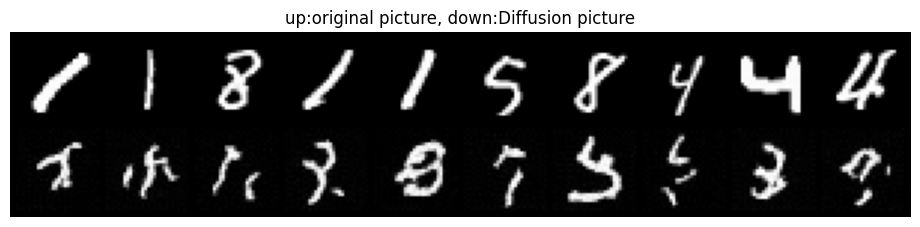

In [11]:
with torch.no_grad():
    real_batch, _ = next(iter(train_loader))              # Âèñ‰∏ÄÊâπÁúüÂØ¶ MNIST
    real_batch = real_batch.to(device)
    num_show = min(10, real_batch.size(0))

    fake_batch = sample(model, n=num_show)

    top = real_batch[:num_show].detach().cpu()
    bottom = fake_batch[:num_show].detach().cpu()
    compare = torch.cat([top, bottom], dim=0)             # [2N,1,28,28]
    show_grid(compare, nrow=num_show, title="up:original picture, down:Diffusion picture")

### 4Á®ÆÊïàÊûúÊØîËºÉ

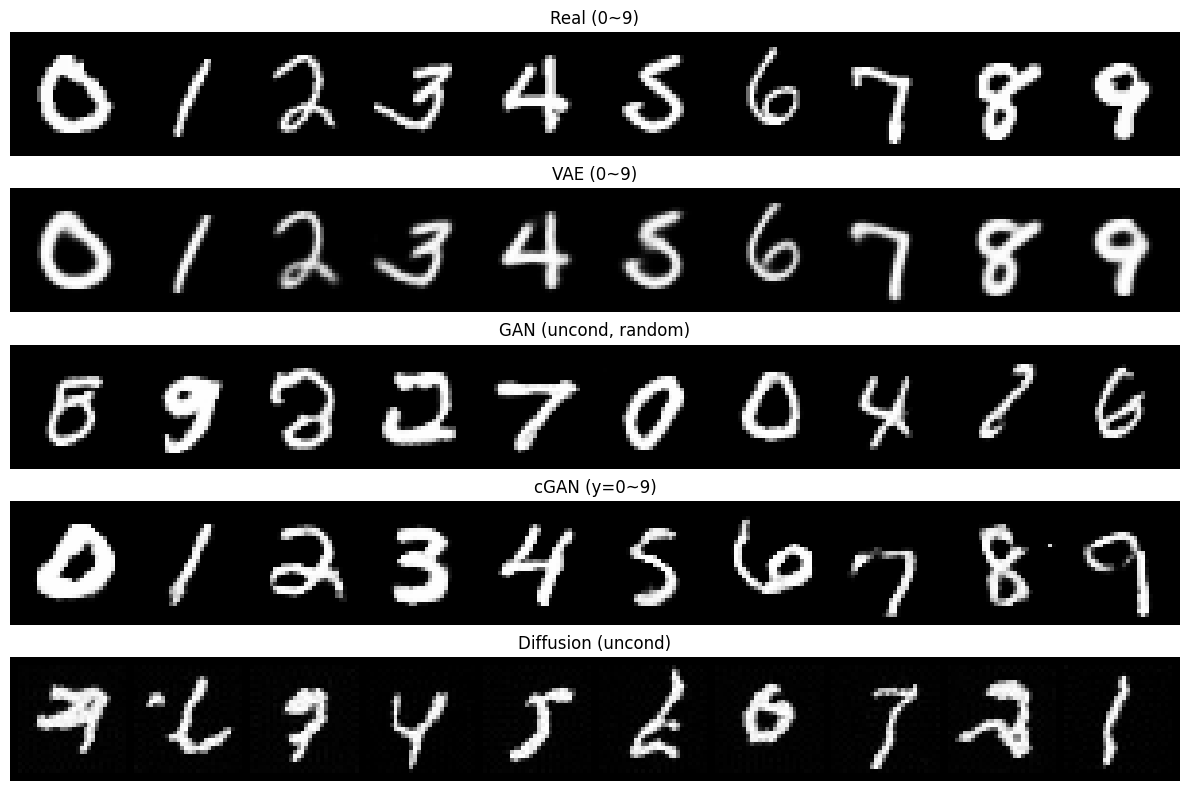

In [12]:
@torch.no_grad()
def get_real_0to9(loader):
    """ÂæûË≥áÊñôÈõÜ‰∏≠ÂêÑÂèñ 1 Âºµ„Äé0..9„ÄèÔºåÂõûÂÇ≥ shape=[10,1,28,28]Ôºà‰æù 0..9 ÊéíÂ∫èÔºâ„ÄÇ"""
    buckets = {i: None for i in range(10)}
    for xb, yb in loader:
        for i in range(xb.size(0)):
            c = int(yb[i])
            if buckets[c] is None:
                buckets[c] = xb[i:i+1]  # [1,1,28,28]
        if all(v is not None for v in buckets.values()):
            break
    rows = [buckets[c] for c in range(10)]
    return torch.cat(rows, dim=0)  # [10,1,28,28]

@torch.no_grad()
def collect_panel_0to9():
    rows, titles = [], []

    # (0) RealÔºöÂéüÂßã 0..9
    real_0to9 = get_real_0to9(train_loader)                 # CPU
    rows.append(real_0to9); titles.append("Real (0~9)")

    # (1) VAEÔºöÂ∞çÂêå‰∏ÄÊâπ 0..9 ÂÅö„ÄéÈáçÂª∫„ÄèÔºåÁ¢∫‰øùÂàóÂá∫‰æÜ‰πüÊòØ 0..9
    if 'vae' in globals():
        x = real_0to9.to(device)
        mu, logvar = vae.enc(x)                             # ÂèñÁ∑®Á¢ºÂô®Ëº∏Âá∫
        recon_logits = vae.dec(mu)                          # Áî®ÂùáÂÄºÈáçÂª∫ÔºàÊõ¥Á©©ÂÆöÔºâ
        vae_recon = torch.sigmoid(recon_logits).cpu()       # [0,1]
        rows.append(vae_recon); titles.append("VAE (0~9)")

    # (2) GANÔºàÁÑ°Ê¢ù‰ª∂ÔºâÔºöÂè™ËÉΩÈö®Ê©ü 10 ÂºµÔºåÁÑ°Ê≥ïÊåáÂÆöÊï∏Â≠óÔºà‰ªç‰øùÁïô‰∏ÄÂàóÂÅöÊØîËºÉÔºâ
    if 'G_gan' in globals():
        z = torch.randn(10, NZ, device=device)
        gan_samples = G_gan(z).cpu()
        rows.append(gan_samples); titles.append("GAN (uncond, random)")

    # (3) cGANÔºöÁõ¥Êé•ÊåáÂÆö y=0..9
    if 'G_cgan' in globals():
        z = torch.randn(10, NZ, device=device)
        y = torch.arange(0, 10, device=device).long()
        cgan_samples = G_cgan(z, y).cpu()
        rows.append(cgan_samples); titles.append("cGAN (y=0~9)")

    # (4) DiffusionÔºàÁÑ°Ê¢ù‰ª∂ÔºâÔºöÈö®Ê©ü 10 Âºµ
    if 'model' in globals():
        diff_samples = sample(model, n=10).cpu()            # ‰Ω†ÁöÑ sample() Âõû [0,1]
        rows.append(diff_samples); titles.append("Diffusion (uncond)")

    return rows, titles

rows, titles = collect_panel_0to9()

# È°ØÁ§∫ÔºöÊØèÂàó 10 Âºµ‰∏¶ÊéíÔºàÊúÄ‰∏äÈù¢ÊòØ Real 0‚Äì9Ôºâ
fig, axes = plt.subplots(len(rows), 1, figsize=(12, 1.6*len(rows)))
if len(rows) == 1:
    axes = [axes]
for ax, imgs, title in zip(axes, rows, titles):
    grid = utils.make_grid(imgs.detach().cpu(), nrow=10, padding=2, normalize=True)
    ax.imshow(grid.permute(1, 2, 0)); ax.set_title(title); ax.axis('off')
plt.tight_layout();
plt.show()

In [13]:
# ============================================================
# ÂõõÊ®°ÂûãË©ï‰º∞Â∑•ÂÖ∑ÔºàVAE / GAN / cGAN / DiffusionÔºâ‚Äî MNIST Áâà
# ÈúÄÊ±ÇÔºö
#   - ‰Ω†Â∑≤Á∂ìÊúâÔºödevice, train_loaderÔºàÂèØÈÅ∏Ôºâ, ‰ª•Âèä‰∏ãÂàóÊ®°Âûã‰∏≠‰ªªÊÑèÂ≠òÂú®ËÄÖÔºö
#       vaeÔºàÂê´ .enc/.dec ‰∏¶Ëº∏Âá∫ logitsÔºâ„ÄÅG_gan„ÄÅG_cgan„ÄÅmodel(DDPM)
#   - ‰Ω†Â∑≤Á∂ìÊúâÔºöLATENTÔºàVAE z Á∂≠Â∫¶ÔºåÈ†êË®≠ 20Ôºâ„ÄÅNZÔºàGAN Âô™ËÅ≤Á∂≠Â∫¶ÔºåÈ†êË®≠ 100Ôºâ
# Áî¢Âá∫Ôºö
#   - ‰∏ÄÂºµ pandas DataFrameÔºöÂê´ÂõõÂ§ßÈù¢ÂêëÊåáÊ®ô
# Ê≥®ÊÑèÔºö
#   - ÂÖ®Á®ãÂÅáË®≠ÂΩ±ÂÉèÂú® [0,1]Ôºå‰∏çÂÅö [-1,1] ÂèçË¶è„ÄÇ
# ============================================================

import time, math, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ----- ÂÆâÂÖ®È†êË®≠ÔºàÂ¶ÇÊûú‰Ω†ÂâçÈù¢Ê≤íÂÆöÁæ©Â∞±Áî®È†êË®≠Ôºâ-----
if 'device' not in globals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if 'LATENT' not in globals():
    LATENT = 20
if 'NZ' not in globals():
    NZ = 100

# ============================================================
# 1) ËºïÈáè MNIST ÂàÜÈ°ûÂô®ÔºàÁï∂‰ΩúÊ∏ÖÊô∞Â∫¶/Â§öÊ®£ÊÄß/ÂàÜ‰ΩàË©ï‰º∞Âô®Ôºâ
#    - Ê∏ÖÊô∞Â∫¶ÔºàClarityÔºâÔºöÁî®ÂàÜÈ°ûÂô®ÁöÑÂπ≥ÂùáÁΩÆ‰ø°Â∫¶/Âπ≥ÂùáÁÜµÁï∂‰ª£ÁêÜ
#    - Á©©ÂÆöÊÄßÔºàStabilityÔºâÔºöÁî®ÂàÜÈ°ûÂô®È†êÊ∏¨ÁöÑÈ°ûÂà•ÂàÜ‰ΩàÂÅöË¶ÜËìãÁéáËàá KL
#    - Â§öÊ®£ÊÄßÔºöÁî®ÂàÜÈ°ûÂô®ÂÄíÊï∏Á¨¨‰∫åÂ±§ÁâπÂæµÂÅöÊñπÂ∑Æ & Âπ≥ÂùáÊàêÂ∞çË∑ùÈõ¢
# ============================================================
clf_transform = transforms.Compose([transforms.ToTensor()])  # ÂàÜÈ°ûÂô®Áî® [0,1]

train_ds_clf = datasets.MNIST(root="./data", train=True,  download=True, transform=clf_transform)
test_ds_clf  = datasets.MNIST(root="./data", train=False, download=True, transform=clf_transform)
train_ld_clf = DataLoader(train_ds_clf, batch_size=256, shuffle=True,  num_workers=2, pin_memory=True)
test_ld_clf  = DataLoader(test_ds_clf,  batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

class TinyMNISTClf(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2),  # 28->14
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2),  # 14->7
        )
        self.fc = nn.Sequential(nn.Linear(64*7*7, 128), nn.ReLU())
        self.out = nn.Linear(128, 10)
    def forward(self, x, return_feat=False):
        h = self.conv(x); h = h.view(x.size(0), -1)
        feat = self.fc(h)
        logit = self.out(feat)
        return (logit, feat) if return_feat else logit

clf = TinyMNISTClf().to(device)
opt = torch.optim.Adam(clf.parameters(), lr=1e-3)

EPOCHS_CLF = 3  # ÊÉ≥Êõ¥Ê∫ñÂèØÊãâÈ´òÔºõ3 epoch Âú® MNIST Â∑≤Â§†Á©©
for ep in range(EPOCHS_CLF):
    clf.train(); loss_sum=0
    for x,y in train_ld_clf:
        x,y = x.to(device), y.to(device)
        loss = F.cross_entropy(clf(x), y)
        opt.zero_grad(); loss.backward(); opt.step()
        loss_sum += loss.item()
    # Á∞°Ê∏¨
    clf.eval(); correct=0; tot=0
    with torch.no_grad():
        for x,y in test_ld_clf:
            x,y = x.to(device), y.to(device)
            pred = clf(x).argmax(1)
            correct += (pred==y).sum().item(); tot += y.numel()
    print(f"[CLF] epoch {ep+1} | train_loss={loss_sum/len(train_ld_clf):.3f} | test_acc={correct/tot:.4f}")

# ============================================================
# 2) Áµ±‰∏ÄÂèñÊ®£Âô®
# ============================================================
@torch.no_grad()
def sample_vae_random(n=1000):
    z = torch.randn(n, LATENT, device=device)
    x = torch.sigmoid(vae.dec(z))      # VAE decoder logits ‚Üí [0,1]
    return x

@torch.no_grad()
def sample_vae_recon(x):               # Áµ¶‰∏ÄÊâπÁúüÂØ¶ÂúñÔºåÂÅöÈáçÂª∫ÔºàÊ™¢Ë¶ñÊ∏ÖÊô∞Â∫¶Áî®Ôºâ
    x = x.to(device)
    mu, logvar = vae.enc(x)
    recon = torch.sigmoid(vae.dec(mu))
    return recon

@torch.no_grad()
def sample_gan(n=1000):
    z = torch.randn(n, NZ, device=device)
    return G_gan(z)                    # ÂÅáË®≠‰Ω†ÁöÑ GAN Â∑≤Ëº∏Âá∫ [0,1]

@torch.no_grad()
def sample_cgan(n=1000, labels=None):
    if labels is None:
        labels = torch.randint(0,10,(n,), device=device).long()
    else:
        labels = labels.to(device).long()
    z = torch.randn(n, NZ, device=device)
    return G_cgan(z, labels), labels   # ÂÅáË®≠Ëº∏Âá∫ [0,1]

@torch.no_grad()
def sample_diffusion_n(n=1000):
    return sample(model, n=n)          # ‰Ω†ÁöÑ DDPM sample() Â∑≤Âõû [0,1]

# ============================================================
# 3) ÊåáÊ®ôË®àÁÆó
# ============================================================

# ---- Ê∏ÖÊô∞Â∫¶ÔºàClarityÔºâÔºöÂπ≥ÂùáÁΩÆ‰ø°Â∫¶‚Üë„ÄÅÂπ≥ÂùáÁÜµ‚ÜìÔºàÂàÜÈ°ûÂô®ÁÇ∫‰ª£ÁêÜÔºâ----
def softmax_confidence(logits):
    prob = logits.softmax(1)
    conf, pred = prob.max(1)
    return pred, conf

@torch.no_grad()
def clarity_by_classifier(x):
    clf.eval()
    logits = []
    B = 256
    for i in range(0, x.size(0), B):
        logits.append(clf(x[i:i+B].to(device)))
    logits = torch.cat(logits, 0)
    pred, conf = softmax_confidence(logits)
    entropy = (-logits.softmax(1)*logits.log_softmax(1)).sum(1).mean().item()
    return conf.mean().item(), entropy  # ÔºàClarityÔºâÂπ≥ÂùáÁΩÆ‰ø°Â∫¶„ÄÅÂπ≥ÂùáÁÜµ

# ÔºàVAE Â∞àÁî®ÔºâÈáçÂª∫ÂìÅË≥™ÂèÉËÄÉÔºöPSNR/SSIMÔºàÂèØÈÅ∏Áî®Ôºâ
@torch.no_grad()
def ssim_simple(x, y, C1=0.01**2, C2=0.03**2):
    mu_x = x.mean(dim=[2,3], keepdim=True); mu_y = y.mean(dim=[2,3], keepdim=True)
    sigma_x = ((x-mu_x)**2).mean(dim=[2,3], keepdim=True)
    sigma_y = ((y-mu_y)**2).mean(dim=[2,3], keepdim=True)
    sigma_xy = ((x-mu_x)*(y-mu_y)).mean(dim=[2,3], keepdim=True)
    ssim = ((2*mu_x*mu_y + C1)*(2*sigma_xy + C2))/((mu_x**2+mu_y**2 + C1)*(sigma_x+sigma_y + C2))
    return ssim.mean().item()

@torch.no_grad()
def psnr(x, y, eps=1e-8):
    mse = F.mse_loss(x, y, reduction='none').mean(dim=[1,2,3])
    return (10*torch.log10(1.0/(mse+eps))).mean().item()

# ---- ÂèØÊéßÊÄßÔºàControl_accÔºâÔºöcGAN ÊåáÂÆö label ‚Üí ÂàÜÈ°ûÂô®È†êÊ∏¨‰∏ÄËá¥Áéá ----
@torch.no_grad()
def controllability_cgan(n=1000):
    labels = torch.arange(0,10, device=device).repeat(n//10 + 1)[:n]
    x, y = sample_cgan(n, labels)
    preds = []
    B=256
    for i in range(0, n, B):
        preds.append(clf(x[i:i+B].to(device)).argmax(1).cpu())
    preds = torch.cat(preds, 0)
    return (preds == y.cpu()).float().mean().item()  # ÔºàControl_accÔºâ

# ---- ÊïàÁéáÔºàEfficiencyÔºâÔºöÁîüÊàêÈÄüÂ∫¶ & ÂèÉÊï∏Èáè ----
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)  # ÔºàParamsÔºâ

@torch.no_grad()
def gen_speed(fn_sampler, n=1000, repeat=3):
    _ = fn_sampler(16)  # È†êÁÜ±
    if torch.cuda.is_available(): torch.cuda.synchronize()
    best = 1e9
    for _ in range(repeat):
        t0 = time.perf_counter()
        _ = fn_sampler(n)
        if torch.cuda.is_available(): torch.cuda.synchronize()
        dt = time.perf_counter()-t0
        best = min(best, dt)
    ips = n / best                                            # ÔºàGen_img_sÔºâ
    return ips, best                                          # ÔºàGen_secÔºâ

# ---- Á©©ÂÆöÊÄßÔºàStabilityÔºâÔºöË¶ÜËìãÁéá„ÄÅÂàÜ‰Ωà KL„ÄÅÂ§öÊ®£ÊÄß ----
@torch.no_grad()
def class_stats(x):
    # È°ûÂà•Ë¶ÜËìãÁéáÔºàÂ§öÂ∞ëÈ°ûË¢´ÁîüÊàêÔºâÔºãËàáÁúüÂØ¶ÂàÜ‰ΩàÁöÑ KLÔºàÁîüÊàê || ÁúüÂØ¶Ôºâ
    clf.eval()
    counts = torch.zeros(10, dtype=torch.long)
    B=256
    for i in range(0, x.size(0), B):
        pred = clf(x[i:i+B].to(device)).argmax(1).cpu()
        for c in pred.tolist(): counts[c]+=1
    p = (counts.float()+1e-8)/counts.sum().float()
    cover = (counts>0).float().mean().item()                  # ÔºàStability_coverÔºâ

    counts_r = torch.zeros(10, dtype=torch.long)
    for xb, yb in test_ld_clf:
        for c in yb.tolist(): counts_r[c]+=1
    q = (counts_r.float()+1e-8)/counts_r.sum().float()
    kl = (p * (p.log() - q.log())).sum().item()               # ÔºàStability_KLÔºâ
    return cover, kl, p.numpy()

@torch.no_grad()
def diversity_features(x):
    # ÁâπÂæµÊñπÂ∑Æ & Âπ≥ÂùáÊàêÂ∞çË∑ùÈõ¢ÔºàÂú®ÂàÜÈ°ûÂô® 128-d ÁâπÂæµÁ©∫ÈñìÔºâ
    clf.eval()
    feats=[]
    B=256
    for i in range(0, x.size(0), B):
        _, f = clf(x[i:i+B].to(device), return_feat=True)
        feats.append(f.cpu())
    Fmat = torch.cat(feats, 0)
    var = Fmat.var(dim=0).mean().item()                       # ÔºàDiversity_varÔºâ
    idx = torch.randperm(Fmat.size(0))[:min(2000, Fmat.size(0))]
    A = Fmat[idx]
    avg_pair = torch.cdist(A, A, p=2).mean().item()           # ÔºàDiversity_pairÔºâ
    return var, avg_pair

# ============================================================
# 4) Ê∏ÖÊô∞Â∫¶ÔºàClarityÔºâÔºöClarity_conf‚Üë / Clarity_entropy‚Üì
#    ÂèØÊéßÊÄßÔºàControl_accÔºâÔºöcGAN ÊåáÂÆö label ‚Üí È†êÊ∏¨‰∏ÄËá¥Áéá
#    ÊïàÁéáÔºàEfficiencyÔºâÔºöGen_img_s / Gen_sec / Params
#    Á©©ÂÆöÊÄßÔºàStabilityÔºâÔºöStability_cover / Stability_KL / Diversity_*
# ============================================================

results = []
N_EVAL = 1000   # ÊØèÂÄãÊ®°ÂûãË©ï‰º∞ÂºµÊï∏ÔºàDiffusion ÂèØË¶ñÈÄüÂ∫¶Ë™øÂ∞èÔºâ
N_SPEED = 500   # Ê∏¨ÈÄüÁî®Êï∏ÈáèÔºàDiffusion ÂÜçÂ∞èÔºâ

# ---- Real baselineÔºàÂÅöÂèÉËÄÉ‰∏äÁïå/‰∏ãÁïåÔºâ----
real_x = []
for xb, _ in test_ld_clf:
    real_x.append(xb)
    if sum(x.size(0) for x in real_x) >= N_EVAL: break
real_x = torch.cat(real_x, 0)[:N_EVAL].to(device)

conf, ent = clarity_by_classifier(real_x)                    # ÔºàClarityÔºâ
cover, kl, p = class_stats(real_x)                           # ÔºàStabilityÔºâ
var, avgpair = diversity_features(real_x)                    # ÔºàStabilityÔºâ
results.append(dict(Model="Real",
                    Clarity_conf=conf,
                    Clarity_entropy=ent,
                    Control_acc="‚Äî",
                    Gen_img_s="‚Äî",
                    Gen_sec="‚Äî",
                    Params="‚Äî",
                    Stability_cover=cover, Stability_KL=kl,
                    Diversity_var=var, Diversity_pair=avgpair))

# ---- VAE ----
if 'vae' in globals():
    xv = sample_vae_random(N_EVAL)
    conf, ent = clarity_by_classifier(xv)
    cover, kl, p = class_stats(xv)
    var, avgpair = diversity_features(xv)
    ips, sec = gen_speed(sample_vae_random, n=N_SPEED)
    results.append(dict(Model="VAE",
                        Clarity_conf=conf,
                        Clarity_entropy=ent,             # Ê∏ÖÊô∞Â∫¶ÔºàClarityÔºâ
                        Control_acc="‚Äî",                                     # ÂèØÊéßÊÄßÔºàÊú¨Áâà VAE ÁÑ°Ê¢ù‰ª∂Ôºâ
                        Gen_img_s=f"{ips:.1f}",
                        Gen_sec=f"{sec:.2f}",        # ÊïàÁéáÔºàEfficiencyÔºâ
                        Params=sum(p.numel() for p in vae.parameters() if p.requires_grad),
                        Stability_cover=cover, Stability_KL=kl,              # Á©©ÂÆöÊÄßÔºàStabilityÔºâ
                        Diversity_var=var, Diversity_pair=avgpair))
    # ÔºàÂèØÈÅ∏ÔºâÈáçÂª∫ÂìÅË≥™ÂèÉËÄÉÔºà‰∏çÈÄ≤Ë°®ÔºâÔºöPSNR/SSIM
    vre = sample_vae_recon(real_x[:128])
    print(f"[VAE] Recon PSNR={psnr(vre, real_x[:128]):.2f} | SSIM={ssim_simple(vre, real_x[:128]):.3f}")

# ---- GAN ----
if 'G_gan' in globals():
    xg = sample_gan(N_EVAL)
    conf, ent = clarity_by_classifier(xg)
    cover, kl, p = class_stats(xg)
    var, avgpair = diversity_features(xg)
    ips, sec = gen_speed(sample_gan, n=N_SPEED)
    results.append(dict(Model="GAN",
                        Clarity_conf=conf,
                        Clarity_entropy=ent,             # Ê∏ÖÊô∞Â∫¶
                        Control_acc="‚Äî",                                     # ÂèØÊéßÊÄßÔºàÁÑ°Ê¢ù‰ª∂Ôºâ
                        Gen_img_s=f"{ips:.1f}",
                        Gen_sec=f"{sec:.2f}",        # ÊïàÁéá
                        Params=sum(p.numel() for p in G_gan.parameters() if p.requires_grad),
                        Stability_cover=cover, Stability_KL=kl,              # Á©©ÂÆöÊÄß
                        Diversity_var=var, Diversity_pair=avgpair))

# ---- cGAN ----
if 'G_cgan' in globals():
    xc, ylab = sample_cgan(N_EVAL)
    conf, ent = clarity_by_classifier(xc)
    ctrl = controllability_cgan(N_EVAL)                    # ÂèØÊéßÊÄßÔºàControl_accÔºâ
    cover, kl, p = class_stats(xc)
    var, avgpair = diversity_features(xc)
    ips, sec = gen_speed(lambda n: sample_cgan(n)[0], n=N_SPEED)
    results.append(dict(Model="cGAN",
                        Clarity_conf=conf,
                        Clarity_entropy=ent,             # Ê∏ÖÊô∞Â∫¶
                        Control_acc=f"{ctrl:.3f}",                           # ÂèØÊéßÊÄß
                        Gen_img_s=f"{ips:.1f}",
                        Gen_sec=f"{sec:.2f}",        # ÊïàÁéá
                        Params=sum(p.numel() for p in G_cgan.parameters() if p.requires_grad),
                        Stability_cover=cover, Stability_KL=kl,              # Á©©ÂÆöÊÄß
                        Diversity_var=var, Diversity_pair=avgpair))

# ---- Diffusion ----
if 'model' in globals():
    N_EVAL_DIFF = min(500, N_EVAL)                           # ÁîüÊàêËºÉÊÖ¢ÔºåÈáèÂ∞è‰∏ÄÈªû
    xd = sample_diffusion_n(N_EVAL_DIFF)
    conf, ent = clarity_by_classifier(xd)
    cover, kl, p = class_stats(xd)
    var, avgpair = diversity_features(xd)
    ips, sec = gen_speed(lambda n: sample_diffusion_n(min(n, 100)), n=100, repeat=2)
    results.append(dict(Model="Diffusion",
                        Clarity_conf=conf,
                        Clarity_entropy=ent,             # Ê∏ÖÊô∞Â∫¶
                        Control_acc="‚Äî",                                     # ÂèØÊéßÊÄßÔºàÁÑ°Ê¢ù‰ª∂Ôºâ
                        Gen_img_s=f"{ips:.1f}",
                        Gen_sec=f"{sec:.2f}",        # ÊïàÁéá
                        Params=sum(p.numel() for p in model.parameters() if p.requires_grad),
                        Stability_cover=cover, Stability_KL=kl,              # Á©©ÂÆöÊÄß
                        Diversity_var=var, Diversity_pair=avgpair))

# ÂΩôÁ∏ΩË°®Ê†º
df = pd.DataFrame(results)
from IPython.display import display
display(df.style.format(precision=3))

[CLF] epoch 1 | train_loss=0.374 | test_acc=0.9727
[CLF] epoch 2 | train_loss=0.079 | test_acc=0.9821
[CLF] epoch 3 | train_loss=0.053 | test_acc=0.9846
[VAE] Recon PSNR=22.63 | SSIM=0.960


#### Clarity_confÔºàÊ∏ÖÊô∞Â∫¶ÔºöÂπ≥ÂùáÁΩÆ‰ø°Â∫¶Ôºâ
ÊàëÂÄëÁî®‰∏ÄÂÄãÂ∞èÂûã MNIST ÂàÜÈ°ûÂô®ÂéªÁúãÁîüÊàêÂúñÁöÑ softmax Ê©üÁéáÔºåÂèñÊØèÂºµÂúñÊúÄÂ§ßÈ°ûÂà•ÁöÑÂπ≥ÂùáÊ©üÁéá„ÄÇ
Ë∂äÈ´òË∂äÊ∏ÖÊ•öÔºàÂàÜÈ°ûÂô®Ë∂äÁ¢∫ÂÆöÈÄôÂºµÂÉèÂì™ÂÄãÊï∏Â≠óÔºâ„ÄÇ

ÁØÑÂúçÂ§ßÁ¥Ñ 0.1ÔΩû1.0Ôºà‰∫ÇÁï´ ‚âà0.1ÔºõË∂ÖÊ∏ÖÊ•ö ‚âà0.99Ôºâ„ÄÇ

#### Clarity_entropyÔºàÊ∏ÖÊô∞Â∫¶ÔºöÂπ≥ÂùáÁÜµÔºâ
Âêå‰∏ÄÂÄãÂàÜÈ°ûÂô®ÁöÑÂπ≥ÂùáÈ†êÊ∏¨ÁÜµÔºà‰∏çÁ¢∫ÂÆöÂ∫¶ÔºâÔºö
‚àí
‚àë
ùëù
log
‚Å°
ùëù
‚àí‚àëplogp„ÄÇ
Ë∂ä‰ΩéË∂äÂ•ΩÔºàË∂ä‰∏çÊ∑∑‰∫ÇÔºâ„ÄÇMNIST 10 È°ûÁöÑ‰∏äÈôêÁ¥Ñ ln(10)‚âà2.30„ÄÇ

Ê∏ÖÊ•öÔºö~0.0‚Äì0.3ÔºõÁ≥äÊàñ‰∫ÇÔºöÊé•Ëøë 2.3„ÄÇ

#### Control_accÔºàÂèØÊéßÊÄßÔºâ
Âè™Â∞çÊ¢ù‰ª∂Ê®°ÂûãÔºàcGAN Á≠âÔºâÊúâÊÑèÁæ©ÔºöÁï∂‰Ω†ÊåáÂÆö labelÔºà0‚Äì9ÔºâË¶ÅÂÆÉÁîüÔºåÊãøÂàÜÈ°ûÂô®ÂéªËæ®Ë≠òÔºåÊúâÂπæÔºÖÁúüÁöÑÁîüÂ∞ç„ÄÇ
Ë∂äÈ´òË∂äÂ•Ω„ÄÇ

ÁÑ°Ê¢ù‰ª∂ÁöÑ VAE / GAN / Diffusion ‚Üí ÈÄôÊ¨ÑÈÄöÂ∏∏Ê®ô„Äå‚Äî„Äç„ÄÇ

#### Gen_img_sÔºàÊïàÁéáÔºöÊØèÁßíÁîüÊàêÂºµÊï∏Ôºâ
‰Ω†ÁöÑÊ®°Âûã‰∏ÄÁßíËÉΩÁîüÂπæÂºµÂúñÔºàÊàëÂÄëÁî®Âõ∫ÂÆö N ÈáèÊ∏¨Ôºâ„ÄÇ
Ë∂äÈ´òË∂äÂ•Ω„ÄÇ‰∏ÄËà¨ GAN/VAE ‚â´ Diffusion„ÄÇ

#### Gen_secÔºàÊïàÁéáÔºöÁîüÊàê N ÂºµÊúÄÁü≠ÊôÇÈñìÔºâ
ÁîüÊàêÂõ∫ÂÆö N ÂºµÂúñÁöÑÊúÄ‰Ω≥ËÄóÊôÇÔºàÁßíÔºâÔºàÂèñÂ§öÊ¨°‰∏≠ÁöÑÊúÄÂø´‰∏ÄÊ¨°Ôºâ„ÄÇ
Ë∂ä‰ΩéË∂äÂ•Ω„ÄÇÈÄôËÉΩÁõ¥ËßÄÂ∞çÊØî Diffusion ÁöÑÊÖ¢ÔºèÂø´„ÄÇ

#### ParamsÔºàÊïàÁéáÔºöÂèÉÊï∏ÈáèÔºâ
ÂèØÁîüÊàêÈÇ£‰∏ÄÂÅ¥ÁöÑÂèÉÊï∏Êï∏ÈáèÔºàVAE=Êï¥ÂÄã VAEÔºõGAN/cGAN=GeneratorÔºõDiffusion=UNetÔºâ„ÄÇ
‰∏çÁõ¥Êé•Á≠âÊñºÂ•ΩÂ£ûÔºå‰ΩÜÂΩ±ÈüøÈÄüÂ∫¶ËàáË®òÊÜ∂È´îÔºõÂêåÁ≠âË°®Áèæ‰∏ãË∂äÂ∞èË∂äÂ•Ω„ÄÇ

#### Stability_coverÔºàÁ©©ÂÆöÊÄßÔºöÈ°ûÂà•Ë¶ÜËìãÁéáÔºâ
ÁîüÊàê‰∏ÄÂ§ßÊâπÂúñÔºåÁî®ÂàÜÈ°ûÂô®Áúã10 ÂÄãÊï∏Â≠óË£°ÊúâÂπæÂÄãÂá∫ÁèæÈÅé„ÄÇ
ÂèñÊØî‰æãÔºà0ÔΩû1ÔºâÔºåË∂äÊé•Ëøë 1 Ë∂äÁ©©„ÄÇ

‰æãÂ¶Ç 0.7 ‰ª£Ë°®Âè™ÁîüÂá∫‰∫Ü 7 Á®ÆÊï∏Â≠óÔºõÂ∏∏Ë¶ãÁöÑ mode collapse ÊúÉËÆìÈÄôÂÄãÂÄºËÆä‰Ωé„ÄÇ

#### Stability_KLÔºàÁ©©ÂÆöÊÄßÔºöÈ°ûÂà•ÂàÜ‰Ωà KLÔºâ
ÁîüÊàêÂúñÁöÑÈ°ûÂà•ÂàÜ‰Ωà vs ÁúüÂØ¶Ë≥áÊñôÂàÜ‰Ωà ÁöÑ KL divergenceÔºàÁîüÊàê || ÁúüÂØ¶Ôºâ„ÄÇ
Ë∂ä‰ΩéË∂äÂ•ΩÔºå0 ‰ª£Ë°®‰∏ÄÊ®°‰∏ÄÊ®£„ÄÇÈ´ò KL Ôºù ÂàÜ‰ΩàÂÅèÊéâÔºèÂ¥©ÊüêÂπæÈ°û„ÄÇ

#### Diversity_varÔºàÁ©©ÂÆöÊÄß/Â§öÊ®£ÊÄßÔºöÁâπÂæµÊñπÂ∑ÆÔºâ
ÊääÁîüÊàêÂúñ‰∏üÈÄ≤ÂàÜÈ°ûÂô®ÔºåÊãøÂÄíÊï∏Á¨¨‰∫åÂ±§ÁâπÂæµÂêëÈáèÔºåË®àÁÆóÁâπÂæµÁ∂≠Â∫¶ÁöÑÂπ≥ÂùáÊñπÂ∑Æ„ÄÇ
Ë∂äÂ§ßÈÄöÂ∏∏Ë∂äÂ§öÊ®£Ôºà‰ΩÜÊ•µÁ´ØÂ§ß‰πüÂèØËÉΩÊòØ‰∫ÇÂô™Ôºâ„ÄÇ

#### Diversity_pairÔºàÁ©©ÂÆöÊÄß/Â§öÊ®£ÊÄßÔºöÂπ≥ÂùáÊàêÂ∞çË∑ùÈõ¢Ôºâ
Âêå‰∏ÄÊâπÁâπÂæµÁöÑÂπ≥ÂùáÂÖ©ÂÖ©Ê≠êÊ∞èË∑ùÈõ¢„ÄÇ
Ë∂äÂ§ßË∂äÂàÜÊï£ÔºùÂúñÊ®£Êõ¥‰∏ç‰∏ÄÊ®£ÔºõÂ§™Â∞èÂèØËÉΩÊ®°ÂºèÂ°åÈô∑„ÄÇ